In [1]:
# Mounting on google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download uw-madison-gi-tract-image-segmentation
! unzip uw-madison-gi-tract-image-segmentation.zip

In [6]:
# Libraries needed for this project

import pandas as pd
import numpy as np

import os
import cv2
import gc

from PIL import Image
import matplotlib.pyplot as plt

import json,itertools
from typing import Optional
from glob import glob

from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.models import load_model, save_model

from keras.layers import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras

from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime

import random

import warnings
warnings.filterwarnings("ignore")

In [7]:
def set_seed(seed=99):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

In [8]:
# defining some initial parameters
batch = 16
epoch = 40
number_of_splits = 5
fold = 2
width = 256
height = 256

# Data Preprocessing

In [9]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [10]:
# Fuction to preprocess the data
def preprocessing(df, subset="train"):
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    if (subset=="train") or (DEBUG):
        DIR="/content/train"
    else:
        DIR="/content/test"
    
    images_total = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    image_x = images_total[0].rsplit("/", 4)[0] 

    pre_processing = []
    for i in range(0, df.shape[0]):
        pre_processing.append(os.path.join(image_x,"case"+str(df["case"].values[i]),"case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),"scans","slice_"+str(df["slice"].values[i])))
    
    df["pp"] = pre_processing

    pre_processing = []
    
    for i in range(0, len(images_total)):
        pre_processing.append(str(images_total[i].rsplit("_",4)[0]))

    temp = pd.DataFrame()
    temp['pp'] = pre_processing
    temp['path'] = images_total
    df = df.merge(temp, on="pp").drop(columns=["pp"])
    df["width"] = df["path"].apply(lambda image_x: int(image_x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda image_x: int(image_x[:-4].rsplit("_",4)[2]))
    del image_x, pre_processing, temp

    resturctured_df = pd.DataFrame({'id': df['id'][::3]})

    if subset=="train":
        resturctured_df['large_bowel'] = df['segmentation'][::3].values
        resturctured_df['small_bowel'] = df['segmentation'][1::3].values
        resturctured_df['stomach'] = df['segmentation'][2::3].values

    resturctured_df['path'] = df['path'][::3].values
    resturctured_df['case'] = df['case'][::3].values
    resturctured_df['day'] = df['day'][::3].values
    resturctured_df['slice'] = df['slice'][::3].values
    resturctured_df['width'] = df['width'][::3].values
    resturctured_df['height'] = df['height'][::3].values

    resturctured_df=resturctured_df.reset_index(drop=True)
    resturctured_df=resturctured_df.fillna('')
    
    if subset=="train":
        resturctured_df['count'] = np.sum(resturctured_df.iloc[:,1:4]!='',axis=1).values
    
    return resturctured_df

In [11]:
train_df = preprocessing(train_df, subset="train")
train_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,/content/train/case123/case123_day20/scans/sli...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,/content/train/case123/case123_day20/scans/sli...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,/content/train/case123/case123_day20/scans/sli...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,/content/train/case123/case123_day20/scans/sli...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,/content/train/case123/case123_day20/scans/sli...,123,20,0005,266,266,0


In [14]:
# Deleting the two cases where images are mislabled
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

In [15]:
# Function to encode RLE
def rle_encode(image):

    flattened_image = image.flatten()
    flattened_image = np.concatenate([[0], flattened_image, [0]])
    runs = np.where(flattened_image[1:] != flattened_image[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Function to decode RLE
def rle_decode(mask_rle, shape, color=1):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [16]:
# Creating function for calculating the dice and iou coefficient which will be used for model evaluation
def dice_coef(y_actual, y_pred, smooth=1):
    y_actual_f = K.flatten(y_actual)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_actual_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_actual_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_actual, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_actual * y_pred), axis=[1,2,3])
    union = K.sum(y_actual,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_actual, y_pred):
    smooth = 1.
    y_actual_f = K.flatten(y_actual)
    y_pred_f = K.flatten(y_pred)
    intersection = y_actual_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_actual_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_actual, y_pred):
    return binary_crossentropy(tf.cast(y_actual, tf.float32), y_pred) + dice_loss(tf.cast(y_actual, tf.float32), y_pred)

**Data generator**

In [17]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = batch, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,height,width,3))
        y = np.empty((self.batch_size,height,width,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)  
            X[i,] = img   
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (height,width))
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X, y
        else: 
            return X
        
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (height,width)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

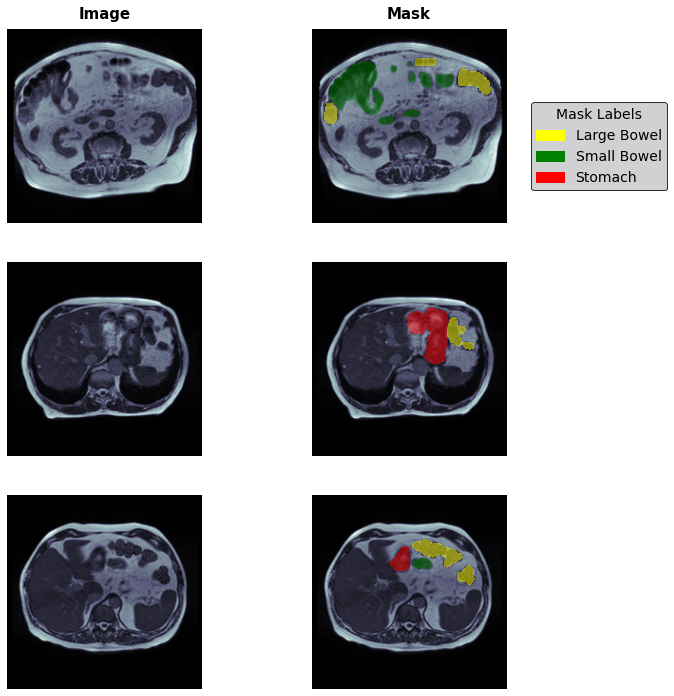

In [18]:
Image_mask = list(train_df[train_df['large_bowel']!=''].sample(batch).index)
Image_mask += list(train_df[train_df['small_bowel']!=''].sample(batch*2).index)
Image_mask += list(train_df[train_df['stomach']!=''].sample(batch*3).index)

# Creating batches using Data Generator
View_batches = DataGenerator(train_df[train_df.index.isin(Image_mask)],shuffle=True)

# Visualizing different images with mask
figures = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

colormap1 = mpl.colors.ListedColormap(colors[0])
colormap2 = mpl.colors.ListedColormap(colors[1])
colormap3= mpl.colors.ListedColormap(colors[2])

for i in range(3):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = figures.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = figures.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=colormap1, alpha=0.5)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=colormap2, alpha=0.5)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=colormap3, alpha=0.5)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

**Group k-fold**

In [20]:
stratified_k_fold = StratifiedGroupKFold(n_splits=number_of_splits, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(stratified_k_fold.split(X=train_df, y=train_df['count'], groups=train_df['case']), 1):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(np.uint8)
tr_ids = train_df[train_df["fold"]!=fold].index
val_ids = train_df[train_df["fold"]==fold].index

X_train = train_df[train_df.index.isin(tr_ids)]
X_valid = train_df[train_df.index.isin(val_ids)]

In [21]:
generated_train_data = DataGenerator(X_train, shuffle=True)
generated_val_data = DataGenerator(X_valid)

In [ ]:
! pip install segmentation-models

In [ ]:
! pip install git+https://github.com/qubvel/segmentation_models

In [24]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:

#Running UNET with resenet34 architecture
model = Unet('resnet34',input_shape=(height, width, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef])

85521592/85521592 [==============================] - 10s 0us/step


In [ ]:
#Running UNET with Inceptionv3 architecture

model1 = Unet('inceptionv3',input_shape=(height, width, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model1.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef])

In [ ]:
#Running LinkNET with ResNet architecture

model2 = Linknet('resnet34',input_shape=(im_height, im_width, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model2.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef])

In [ ]:
model.summary()

In [ ]:
# Plain UNET Model

In [ ]:
#Please uncomment and run

################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [25]:
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/UNET_model_main_correct_check.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

learning_rate = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    min_delta=0.0001,
)


early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

In [ ]:
# Training the model
semantic_model = model.fit(
    generated_train_data,
    validation_data=generated_val_data,
    callbacks=[model_checkpoint, 
               early_stopping, 
               learning_rate],
    use_multiprocessing=False,
    workers=4,
    epochs=epoch
)

In [ ]:
model.load_weights('/content/drive/MyDrive/UNET_model_main_correct.h5')

**Learning curves**

In [ ]:
model_history = pd.DataFrame(semantic_model.history)
model_history.to_csv('/content/drive/MyDrive/UNET_model_main_correct_check.csv')

**Preview predictions**

In [ ]:
def preview_predictions(predictions_batch, preds, Threshold):
  
  fig = plt.figure(figsize=(10, 25))
  gs = gridspec.GridSpec(nrows=8, ncols=3)
  colors = ['yellow','green','red']
  labels = ["Large Bowel", "Small Bowel", "Stomach"]
  patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

  colormap1 = mpl.colors.ListedColormap(colors[0])
  colormap2 = mpl.colors.ListedColormap(colors[1])
  colormap3= mpl.colors.ListedColormap(colors[2])

  for i in range(len(predictions_batch)):
      images, mask = predictions_batch[i]
      sample_img=images[0,:,:,0]
      mask1=mask[0,:,:,0]
      mask2=mask[0,:,:,1]
      mask3=mask[0,:,:,2]
      
      pre=preds[i]
      predict1=pre[:,:,0]
      predict2=pre[:,:,1]
      predict3=pre[:,:,2]
      
      predict1= (predict1 > Threshold).astype(np.float32)
      predict2= (predict2 > Threshold).astype(np.float32)
      predict3= (predict3 > Threshold).astype(np.float32)
      
      ax0 = fig.add_subplot(gs[i, 0])
      im = ax0.imshow(sample_img, cmap='bone')
      ax0.set_title("MRI Image", fontsize=12, y=1.01)
      #--------------------------
      ax1 = fig.add_subplot(gs[i, 1])
      ax1.set_title("Actual Mask", fontsize=12,  y=1.01)
      l0 = ax1.imshow(sample_img, cmap='bone')
      l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=colormap1, alpha=0.9)
      l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=colormap2, alpha=0.9)
      l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=colormap3, alpha=0.9)
      #--------------------------
      ax2 = fig.add_subplot(gs[i, 2])
      ax2.set_title("Predicted mask", fontsize=12, y=1.01)
      l0 = ax2.imshow(sample_img, cmap='bone')
      l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=colormap1, alpha=0.9)
      l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=colormap2, alpha=0.9)
      l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=colormap3, alpha=0.9)
    

      _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
      colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
      plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


8/8 [==============================] - 2s 11ms/step


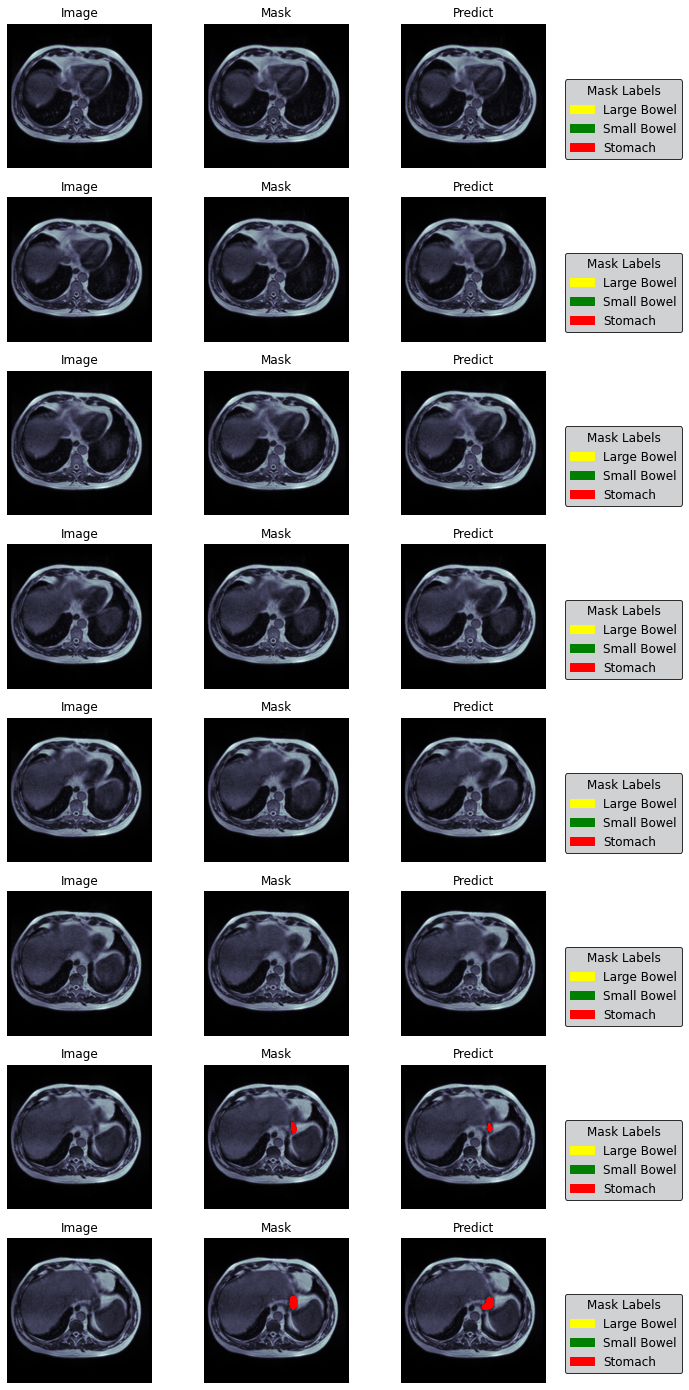

In [ ]:
predictions_batch = DataGenerator(X_valid.iloc[200:208,:], batch_size = 1, subset="train", shuffle=False)
preds = model.predict_generator(predictions_batch,verbose=1)

preview_predictions(predictions_batch, preds, Threshold = 0.5)
